# Dự án: Dự đoán Kết quả Tennis ATP và Hệ thống Elo Lai

## 1. Clone và Cài đặt Môi trường

In [14]:
# Clone repository
!git clone https://github.com/chtr302/atp_match_prediction
%cd atp_match_prediction


Cloning into 'atp_match_prediction'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 59 (delta 15), reused 54 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 752.02 KiB | 654.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.
/Users/conghau/H/Post and Telecomminucation Instotues of Technology/4rd/Machine Learning/project/atp_match_prediction/atp_match_prediction


## 2. Cài đặt Thư viện và Cấu hình

In [15]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Cấu hình hiển thị
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## 3. Hệ thống Hybrid Elo (Tự xây dựng)
Đây là thuật toán tính điểm sức mạnh động dựa trên cả phong độ tổng quát và mặt sân.

In [16]:
class TennisEloModel:
    def __init__(self, k_factor=20, surface_weight=0.5):
        self.k = k_factor
        self.alpha = surface_weight
        self.overall_elo = {}
        self.surface_elo = {}
        self.start_elo = 1500

    def get_elo(self, pid, surface):
        overall = self.overall_elo.get(pid, self.start_elo)
        if pid not in self.surface_elo: self.surface_elo[pid] = {}
        s_elo = self.surface_elo[pid].get(surface, self.start_elo)
        final = (1 - self.alpha) * overall + self.alpha * s_elo
        return final, overall, s_elo

    def update(self, wid, lid, surface):
        w_final, w_over, w_surf = self.get_elo(wid, surface)
        l_final, l_over, l_surf = self.get_elo(lid, surface)
        
        prob_w = 1 / (1 + 10 ** ((l_final - w_final) / 400))
        delta = self.k * (1 - prob_w)
        
        self.overall_elo[wid] = w_over + delta
        self.overall_elo[lid] = l_over - delta
        
        if wid not in self.surface_elo: self.surface_elo[wid] = {}
        if lid not in self.surface_elo: self.surface_elo[lid] = {}
        
        self.surface_elo[wid][surface] = w_surf + delta
        self.surface_elo[lid][surface] = l_surf - delta

    def fit_transform(self, df):
        p1_elos, p2_elos = [], []
        for _, row in df.iterrows():
            p1, p2, surf = row['p1_id'], row['p2_id'], row['surface']
            target = row['target']
            
            e1, _, _ = self.get_elo(p1, surf)
            e2, _, _ = self.get_elo(p2, surf)
            
            p1_elos.append(e1)
            p2_elos.append(e2)
            
            if target == 1: self.update(p1, p2, surf)
            else: self.update(p2, p1, surf)
            
        df['p1_elo'] = p1_elos
        df['p2_elo'] = p2_elos
        df['elo_diff'] = df['p1_elo'] - df['p2_elo']
        return df

## 4. Tiền xử lý dữ liệu (Data Pipeline)
Bao gồm: Load data, Rolling Stats, Restructuring (Chống Leakage) và Clean.

In [17]:
def process_data(data_path='data'):
    # 1. Load Data
    files = glob.glob(os.path.join(data_path, 'atp_matches_*.csv'))
    if not files: return None
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
    df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)
    
    # 2. Rolling Stats (Form)
    last_5, surface_stats = {}, {}
    w_forms, l_forms, w_surfs, l_surfs = [], [], [], []
    
    for _, row in df.iterrows():
        wid, lid, surf = row['winner_id'], row['loser_id'], row['surface']
        
        w_forms.append(np.mean(last_5.get(wid, [0])))
        l_forms.append(np.mean(last_5.get(lid, [0])))
        
        ws = surface_stats.get(wid, {}).get(surf, [0, 0])
        w_surfs.append(ws[0]/ws[1] if ws[1]>0 else 0)
        ls = surface_stats.get(lid, {}).get(surf, [0, 0])
        l_surfs.append(ls[0]/ls[1] if ls[1]>0 else 0)
        
        # Update
        last_5.setdefault(wid, []).append(1)
        if len(last_5[wid]) > 5: last_5[wid].pop(0)
        last_5.setdefault(lid, []).append(0)
        if len(last_5[lid]) > 5: last_5[lid].pop(0)
        
        surface_stats.setdefault(wid, {}).setdefault(surf, [0, 0])
        surface_stats[wid][surf][0] += 1; surface_stats[wid][surf][1] += 1
        surface_stats.setdefault(lid, {}).setdefault(surf, [0, 0])
        surface_stats[lid][surf][1] += 1
        
    df['winner_form'] = w_forms; df['loser_form'] = l_forms
    df['winner_surf'] = w_surfs; df['loser_surf'] = l_surfs
    
    # 3. Restructure (Anti-Leakage)
    np.random.seed(42)
    swap = np.random.rand(len(df)) < 0.5
    new_df = pd.DataFrame({'tourney_date': df['tourney_date']})
    
    feats = ['id', 'rank', 'age', 'ht', 'form', 'surf', 'seed']
    for f in feats:
        w_col, l_col = f'winner_{f}', f'loser_{f}'
        # Handle special names
        if f == 'form': w_col, l_col = 'winner_form', 'loser_form'
        if f == 'surf': w_col, l_col = 'winner_surf', 'loser_surf'
        
        if w_col in df.columns:
            new_df[f'p1_{f}'] = np.where(swap, df[l_col], df[w_col])
            new_df[f'p2_{f}'] = np.where(swap, df[w_col], df[l_col])
            
    new_df['target'] = np.where(swap, 0, 1)
    new_df['surface'] = df['surface']
    
    # 4. Calculate Elo
    elo_model = TennisEloModel()
    new_df = elo_model.fit_transform(new_df)
    
    # 5. Clean & Engineer
    new_df.dropna(subset=['p1_rank', 'p2_rank', 'p1_ht', 'p2_ht'], inplace=True)
    new_df['rank_diff'] = new_df['p1_rank'] - new_df['p2_rank']
    new_df['age_diff'] = new_df['p1_age'] - new_df['p2_age']
    new_df['ht_diff'] = new_df['p1_ht'] - new_df['p2_ht']
    new_df['form_diff'] = new_df['p1_form'] - new_df['p2_form']
    new_df['surf_diff'] = new_df['p1_surf'] - new_df['p2_surf']
    
    return new_df

print("Đang xử lý dữ liệu...")
df_clean = process_data()
print(f"Dữ liệu sạch: {df_clean.shape if df_clean is not None else 'None'}")

Đang xử lý dữ liệu...
Dữ liệu sạch: (12920, 25)


## 5. Huấn luyện Mô hình Ensemble
Sử dụng Soft Voting với 4 model: Logistic Regression, Random Forest, XGBoost và SVM.

In [18]:
# Prepare Data
if df_clean is not None and len(df_clean) > 0:
    train_size = int(len(df_clean) * 0.8)
    features = ['rank_diff', 'elo_diff', 'age_diff', 'ht_diff', 'form_diff', 'surf_diff']

    X = df_clean[features]
    y = df_clean['target']

    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Define Models
    models = [
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10)),
        ('xgb', XGBClassifier(n_estimators=100, max_depth=5)),
        ('svm', SVC(probability=True))
    ]

    # Voting Ensemble
    voting_clf = VotingClassifier(estimators=models, voting='soft')
    voting_clf.fit(X_train_s, y_train)

    # Evaluate
    y_pred = voting_clf.predict(X_test_s)
    y_prob = voting_clf.predict_proba(X_test_s)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    print(f"--- KẾT QUẢ SOFT VOTING ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Log Loss: {loss:.4f}")
    print(f"ROC-AUC : {auc_score:.4f}")
else:
    print("Dữ liệu không hợp lệ. Vui lòng kiểm tra lại đường dẫn dữ liệu!")

--- KẾT QUẢ SOFT VOTING ---
Accuracy: 0.6451
Log Loss: 0.6238
ROC-AUC : 0.7087


## 6. Trực quan hóa Kết quả

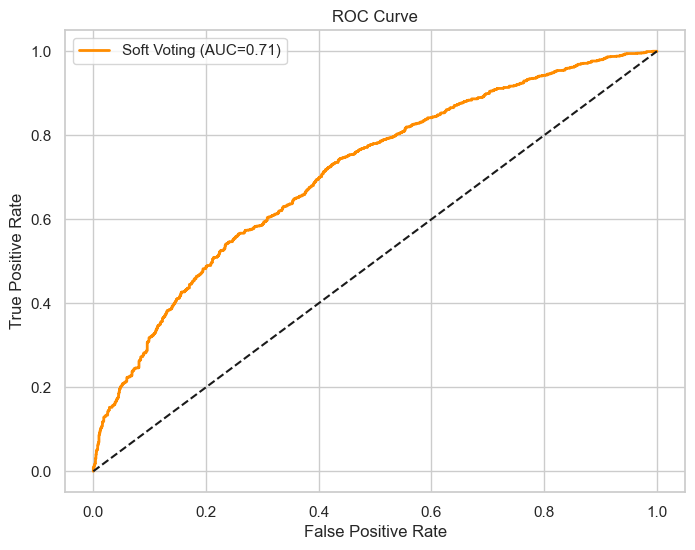

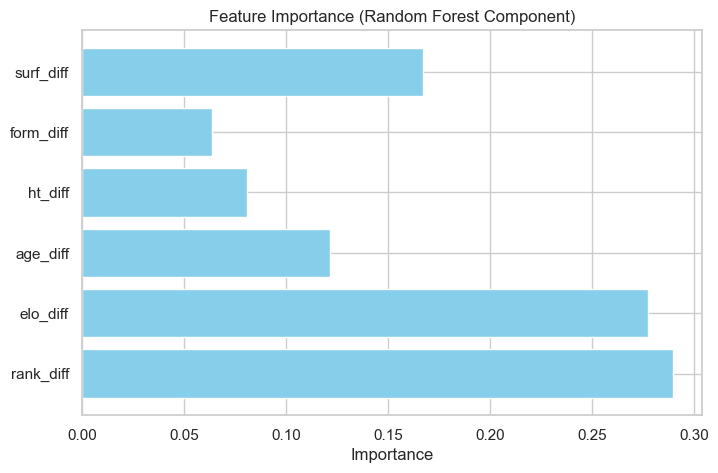

In [19]:
if df_clean is not None and len(df_clean) > 0:
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Soft Voting (AUC={auc_score:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Feature Importance (Using RF inside)
    rf_model = voting_clf.named_estimators_['rf']
    imps = rf_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.barh(features, imps, color='skyblue')
    plt.title('Feature Importance (Random Forest Component)')
    plt.xlabel('Importance')
    plt.show()
else:
    print("Không thể trực quan hóa do dữ liệu không hợp lệ.")

## 7. Tích hợp đầy đủ các thành phần để huấn luyện toàn bộ pipeline

In [20]:
# Import các thư viện đầy đủ theo pipeline
import pandas as pd
import numpy as np
import glob, os, traceback, sys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Định nghĩa các lớp model đầy đủ
class ModelTrainer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = []

        self.pipelines = {
            'Logistic Regression': Pipeline([
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(
                    max_iter=1000,
                    class_weight='balanced',
                    random_state=self.random_state
                ))
            ]),
            'Random Forest': Pipeline([
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(
                    n_estimators=300,
                    class_weight='balanced',
                    random_state=self.random_state,
                    n_jobs=-1
                ))
            ]),
            'XGBoost': Pipeline([
                ('scaler', StandardScaler()),
                ('model', XGBClassifier(
                    n_estimators=300,
                    max_depth=5,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    eval_metric='logloss',
                    random_state=self.random_state,
                    n_jobs=-1
                ))
            ]),
            'SVM': Pipeline([
                ('scaler', StandardScaler()),
                ('model', SVC(
                    kernel='rbf',         # Radial Basis Function (Phi tuyến)
                    C=1.0,                # Regularization (C càng nhỏ càng chống overfitting)
                    probability=True,     # Bắt buộc để dùng Soft Voting
                    class_weight='balanced',
                    random_state=self.random_state
                ))
            ])
        }

    def train_evaluate(self, X_train, y_train, X_test, y_test):
        print("\n--- HUẤN LUYỆN MÔ HÌNH CƠ SỞ (BASE MODELS) ---")

        for name, pipe in self.pipelines.items():
            print(f"Đang train {name}...")
            pipe.fit(X_train, y_train)
            self.models[name] = pipe

            y_pred = pipe.predict(X_test)
            y_prob = pipe.predict_proba(X_test)[:, 1]

            res = {
                'Model': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'F1-score': f1_score(y_test, y_pred),
                'ROC-AUC': roc_auc_score(y_test, y_prob),
                'Log Loss': log_loss(y_test, y_prob)
            }
            self.results.append(res)
            print(f"  -> Accuracy: {res['Accuracy']:.4f}, AUC: {res['ROC-AUC']:.4f}")

        return pd.DataFrame(self.results)

    def get_trained_models(self):
        return self.models

class EnsembleTrainer:
    def __init__(self, trained_models):
        self.models = trained_models
        self.results = []

    def soft_voting(self, X_test, y_test):
        print("\n--- ENSEMBLE: SOFT VOTING ---")
        probs = []
        valid_models = []

        # Duyệt qua tất cả model có trong danh sách
        for name, model in self.models.items():
            try:
                p = model.predict_proba(X_test)[:, 1]
                probs.append(p)
                valid_models.append(name)
            except AttributeError:
                print(f"Bỏ qua {name} (không có predict_proba)")

        print(f"Đang vote dựa trên: {', '.join(valid_models)}")

        if not probs:
            return None

        y_prob_avg = np.mean(probs, axis=0)
        y_pred_avg = (y_prob_avg >= 0.5).astype(int)

        res = {
            'Model': 'Ensemble Soft Voting',
            'Accuracy': accuracy_score(y_test, y_pred_avg),
            'Precision': precision_score(y_test, y_pred_avg),
            'F1-score': f1_score(y_test, y_pred_avg),
            'ROC-AUC': roc_auc_score(y_test, y_prob_avg),
            'Log Loss': log_loss(y_test, y_prob_avg)
        }
        self.results.append(res)
        print(f"  -> Accuracy: {res['Accuracy']:.4f}, AUC: {res['ROC-AUC']:.4f}")
        return res

    def stacking(self, X_train, y_train, X_test, y_test):
        print("\n--- ENSEMBLE: STACKING ---")
        meta_train_list = []
        meta_test_list = []
        valid_models = []

        for name, model in self.models.items():
            try:
                # Cần ensure tính tương thích chiều dữ liệu
                train_prob = model.predict_proba(X_train)[:, 1]
                test_prob = model.predict_proba(X_test)[:, 1]

                meta_train_list.append(train_prob)
                meta_test_list.append(test_prob)
                valid_models.append(name)
            except AttributeError:
                pass

        X_train_meta = np.column_stack(meta_train_list)
        X_test_meta = np.column_stack(meta_test_list)

        # Meta-model (Logistic Regression)
        meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
        meta_model.fit(X_train_meta, y_train)

        y_prob_stack = meta_model.predict_proba(X_test_meta)[:, 1]
        y_pred_stack = (y_prob_stack >= 0.5).astype(int)

        res = {
            'Model': 'Ensemble Stacking',
            'Accuracy': accuracy_score(y_test, y_pred_stack),
            'Precision': precision_score(y_test, y_pred_stack),
            'F1-score': f1_score(y_test, y_pred_stack),
            'ROC-AUC': roc_auc_score(y_test, y_prob_stack),
            'Log Loss': log_loss(y_test, y_prob_stack)
        }
        self.results.append(res)
        print(f"  -> Accuracy: {res['Accuracy']:.4f}, AUC: {res['ROC-AUC']:.4f}")
        return res

    def get_results(self):
        return pd.DataFrame(self.results)

# Thực hiện huấn luyện toàn bộ pipeline
if df_clean is not None and len(df_clean) > 0:
    # Chia tập dữ liệu
    split_idx = int(len(df_clean) * 0.8)
    train_data = df_clean.iloc[:split_idx]
    test_data = df_clean.iloc[split_idx:]
    
    print(f"Kích thước tập Train: {train_data.shape}")
    print(f"Kích thước tập Test: {test_data.shape}")
    
    X_train = train_data[features]
    y_train = train_data['target'].astype(int)
    
    X_test = test_data[features]
    y_test = test_data['target'].astype(int)
    
    # Huấn luyện các mô hình cơ sở
    trainer = ModelTrainer()
    base_results = trainer.train_evaluate(X_train, y_train, X_test, y_test)
    
    # Huấn luyện Ensemble
    trained_models = trainer.get_trained_models()
    ensemble = EnsembleTrainer(trained_models)
    
    ensemble.soft_voting(X_test, y_test)
    ensemble.stacking(X_train, y_train, X_test, y_test)
    
    ensemble_results = ensemble.get_results()
    
    # Tổng hợp kết quả
    final_results = pd.concat([base_results, ensemble_results], ignore_index=True)
    final_results = final_results.sort_values(by='Accuracy', ascending=False)
    
    print("\n--- KẾT QUẢ CUỐI CÙNG ---")
    print(final_results)
else:
    print("Không thể thực hiện huấn luyện do dữ liệu không hợp lệ.")

Kích thước tập Train: (10336, 25)
Kích thước tập Test: (2584, 25)

--- HUẤN LUYỆN MÔ HÌNH CƠ SỞ (BASE MODELS) ---
Đang train Logistic Regression...
  -> Accuracy: 0.6474, AUC: 0.7088
Đang train Random Forest...
  -> Accuracy: 0.6370, AUC: 0.6923
Đang train XGBoost...
  -> Accuracy: 0.6482, AUC: 0.7031
Đang train SVM...
  -> Accuracy: 0.6451, AUC: 0.6929

--- ENSEMBLE: SOFT VOTING ---
Đang vote dựa trên: Logistic Regression, Random Forest, XGBoost, SVM
  -> Accuracy: 0.6393, AUC: 0.7077

--- ENSEMBLE: STACKING ---
  -> Accuracy: 0.6324, AUC: 0.6858

--- KẾT QUẢ CUỐI CÙNG ---
                  Model  Accuracy  Precision  F1-score   ROC-AUC  Log Loss
2               XGBoost  0.648220   0.647242  0.646990  0.703117  0.632147
0   Logistic Regression  0.647446   0.644666  0.648398  0.708754  0.624871
3                   SVM  0.645124   0.639160  0.650134  0.692871  0.636658
4  Ensemble Soft Voting  0.639319   0.638199  0.638199  0.707674  0.624088
1         Random Forest  0.636997   0.640902